In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime

from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from pandas import datetime
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from math import sqrt

import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.width', None)

<ipython-input-2-bad7aa229f9d>:10: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [4]:
df = pd.read_csv('NOVAIMS_MAA_final.csv')
df = df.drop(columns=['Unnamed: 0'])

In [5]:
df

,ProductFamily_ID,ProductCategory_ID,ProductBrand_ID,ProductName_ID,ProductPackSKU_ID,Point-of-Sale_ID,Date,Quantity,Total_Sales
0,16,11,306,649,1970,1,2017-03-04,2.0,1540.0
1,16,11,306,649,1970,1,2016-05-02,4.0,3080.0
2,16,11,306,649,1970,1,2016-10-24,2.0,1540.0
3,16,11,306,649,1970,1,2017-10-13,2.0,1620.0
4,16,11,306,649,1970,1,2017-10-14,2.0,1620.0
...,...,...,...,...,...,...,...,...,...
91187499,4,34,279,577,1813,410,2016-01-28,1.0,643.0
91187500,4,34,279,577,1813,410,2016-04-20,1.0,638.0
91187501,4,34,279,577,1813,410,2016-04-25,1.0,652.0
91187502,4,34,279,577,1813,410,2016-04-28,1.0,643.0


In [6]:
df_forecast = df[['ProductName_ID', 'Point-of-Sale_ID', 'Date', 'Quantity']]

In [7]:
for i in list(df_forecast.columns):
    print(i,df_forecast[i].nunique())

ProductName_ID 2820
Point-of-Sale_ID 410
Date 1401
Quantity 178


In [8]:
df_forecast['Date'].max()

'2019-11-01'

In [9]:
df_forecast

,ProductName_ID,Point-of-Sale_ID,Date,Quantity
0,649,1,2017-03-04,2.0
1,649,1,2016-05-02,4.0
2,649,1,2016-10-24,2.0
3,649,1,2017-10-13,2.0
4,649,1,2017-10-14,2.0
...,...,...,...,...
91187499,577,410,2016-01-28,1.0
91187500,577,410,2016-04-20,1.0
91187501,577,410,2016-04-25,1.0
91187502,577,410,2016-04-28,1.0


In [10]:
point_of_sale = 1
product_name = 481

data_product_POS = df_forecast[(df_forecast['Point-of-Sale_ID']==point_of_sale) & (df_forecast['ProductName_ID']==product_name)]

In [11]:
data_product_POS['Date'] = pd.to_datetime(data_product_POS.Date)
data_product_POS_weekly = data_product_POS[['Quantity', 'Date']].set_index('Date').resample('W').sum()

In [12]:
data_product_POS_weekly

,Quantity
Date,
2016-01-03,34.0
2016-01-10,75.0
2016-01-17,64.0
2016-01-24,40.0
2016-01-31,39.0
...,...
2019-10-06,29.0
2019-10-13,30.0
2019-10-20,19.0


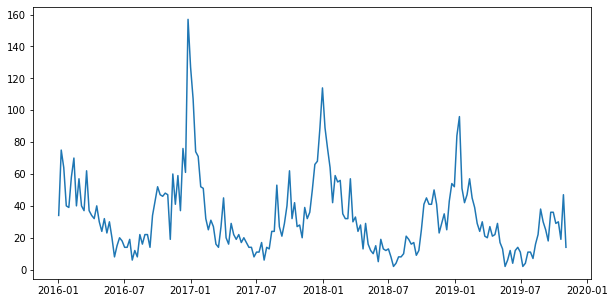

In [13]:
series = data_product_POS_weekly
values = series.values
# plot dataset
plt.figure(figsize=(10,5)) 
pyplot.plot(data_product_POS_weekly)
pyplot.show()

In [16]:
!pip install tabulate

In [17]:
from tabulate import tabulate
import numpy as np

def accuracy(actual,predicted):
    
    """
    Args:
        actual: actual values as numpy array or time series
        predicted: predicted values as numpy array or time series
        
    Returns:
        accuracy_dict: dictionary of accuracy measures
        
    
    prints accuracy measures for forecasting and returns them as a dictionary
    """
    
    #convert to np array if series
    try:
        actual = actual.values
    except:
        pass
    try:
        predicted = predicted.values
    except:
        pass
    actual = actual.astype(float)
    predicted = np.array(predicted)
    predicted = predicted.astype(float)
    
    #if any nan values, convert to 0
    actual[np.isnan(actual)] = 0.0
    predicted[np.isnan(predicted)] = 0.0
    # ----------------------------Scale independent metrics------------------------

    # The mean absolute percentage error (MAPE), is a measure of prediction
    # accuracy of a forecasting method in statistics. The 'min_val' variable is
    # used to fill zeros in test data, if any. Filling zero with a constant helps
    # to avoid division by zero error
    def mean_absolute_percentage_error(y_true, y_pred, min_val=1):
        y_true = y_true + min_val
        return np.mean(np.abs((y_true - y_pred) / y_true))


    # SMAPE is an alternative for MAPE when there are zeros in the testing data. It
    # scales the absolute percentage by the sum of forecast and observed values
    def s_mean_absolute_percentage_error(y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / ((y_true + y_pred)/2)))

    #returns average error
    def mean_error(y_true,y_pred):
        return np.mean(y_true - y_pred)
    
    # MAE is used to measure how close the forecast is to observed value
    def mean_absolute_error(y_true, y_pred):
        return np.mean(abs(y_true - y_pred))
    
    # -----------------------------Scale dependent metrics-------------------------


    # In statistics, the mean squared error (MSE) of an estimator measures the
    # average of the squares of the errors. The squaring is necessary to remove any
    # negative signs. It also gives more weight to larger differences
    def mean_squared_error(y_true, y_pred):
        return np.mean((y_true - y_pred)**2)


    # RMSE is the standard deviation of the residuals. It shares the same
    # properties as MSE. The square root is used to dampen the magnitude of errors
    # caused by squaring them.
    def root_mean_squared_error(y_true, y_pred):
        return np.sqrt(np.mean((y_true - y_pred)**2))


    # It measures the total squared deviation of forecasted observations, from the
    # observed values
    def sum_of_squared_error(y_true, y_pred):
        return np.sum((y_true - y_pred)**2)


    # Thiels U accuracy measure (lies between 0  and 1, closer to 0 is more accurate)
    def theil_u_statistic(y_true, y_pred):
        return np.sqrt(np.sum((y_pred - y_true)**2)/np.sum(y_true**2))
    
    def autocorrelation_lag_1(y_true, y_pred, lag=1):
        error = y_true - y_pred
        # Slice the relevant subseries based on the lag
        y1 = error[:(len(error)-lag)]
        y2 = error[lag:]
        # Subtract the mean of the whole series x to calculate Cov
        sum_product = np.sum((y1-np.mean(error))*(y2-np.mean(error)))
        # Normalize with var of whole series
        return sum_product / ((len(error) - lag) * np.var(error))

    MAPE = mean_absolute_percentage_error(actual,predicted)
    SMAPE = s_mean_absolute_percentage_error(actual,predicted)
    ME = mean_error(actual,predicted)
    MAE = mean_absolute_error(actual,predicted)
    MSE = mean_squared_error(actual,predicted)
    RMSE = root_mean_squared_error(actual,predicted)
    SSE = sum_of_squared_error(actual,predicted)
    ThielsU = theil_u_statistic(actual,predicted)
    ACF1 = autocorrelation_lag_1(actual,predicted)
    
    print(tabulate([[MAPE,SMAPE,ME,MAE,MSE,RMSE,ThielsU,ACF1]], headers=['MAPE','SMAPE','ME','MAE','MSE','RMSE','ThielsU','ACF1']))
    
    accuracy_dict = {'MAPE':MAPE,'SMAPE':SMAPE,'ME':ME,'MAE':MAE,'MSE':MSE,'RMSE':RMSE,'ThielsU':ThielsU,'ACF1':ACF1}
    
    #return accuracy_dict

MAE: 10.714
    MAPE     SMAPE         ME     MAE      MSE     RMSE    ThielsU     ACF1
--------  --------  ---------  ------  -------  -------  ---------  -------
0.566496  0.412031  -0.922189  10.714  230.269  15.1746   0.444465  0.16204


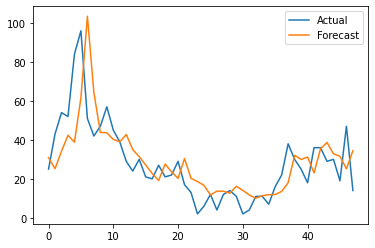

In [18]:
# forecast with xgboost
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from matplotlib import pyplot
from tabulate import tabulate


# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = XGBRegressor(objective='reg:squarederror',
                         colsample_bytree = 0.5,
                         eta= 0.15,
                         learning_rate = 0.01,
                         max_depth = 3,
                         min_child_weight = 3,
                         subsample = 0.5,
                         n_estimators = 500
                        )
    
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict(asarray([testX]))
    return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data):
    n_test = int(len(data)*0.25)
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = xgboost_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        #print('>actual=%.1f, forecast=%.1f' % (testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions

values = series.values
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
# evaluate
mae, y, yhat = walk_forward_validation(data)
print('MAE: %.3f' % mae)

accuracy(y, yhat)

# plot expected vs preducted
pyplot.plot(y, label='Actual')
pyplot.plot(yhat, label='Forecast')
pyplot.legend()
pyplot.show()

In [34]:
store_results = pd.DataFrame([0,0,0,0,0,0], index=['Date','Actual', 'Model_Forecast', 'Benchmark', 'POS', 'Product']).T
store_results

,Date,Actual,Model_Forecast,Benchmark,POS,Product
0,0,0,0,0,0,0


In [35]:
store_metrics = pd.DataFrame([0,0,0,0,0,0], 
                             index=['MAPE_Model', 'MAPE_Benchmark', 'MSE_Model', 'MSE_Benchmark', 'POS', 'Product']).T
store_metrics

,MAPE_Model,MAPE_Benchmark,MSE_Model,MSE_Benchmark,POS,Product
0,0,0,0,0,0,0


In [36]:
def mean_absolute_percentage_error(y_true, y_pred, min_val=1):
        y_true = y_true + min_val
        return np.mean(np.abs((y_true - y_pred) / y_true))

def mean_squared_error(y_true, y_pred):
        return np.mean((y_true - y_pred)**2)

In [37]:
top10_prod = pd.DataFrame(df_forecast.groupby(["ProductName_ID"])['Quantity'].sum()).sort_values(by='Quantity', ascending=False)[:10].index.tolist()
top10_pos =pd.DataFrame(df_forecast.groupby(["Point-of-Sale_ID"])['Quantity'].sum()).sort_values(by='Quantity', ascending=False)[:10].index.tolist()

In [38]:
top10_pos

[292, 78, 280, 272, 92, 103, 383, 282, 48, 359]

In [39]:
for pos in top10_pos:
    for prod in top10_prod:
        print(pos,prod)
        data_product_POS = df_forecast[(df_forecast['Point-of-Sale_ID']==pos) & (df_forecast['ProductName_ID']==prod)]
        data_product_POS['Date'] = pd.to_datetime(data_product_POS.Date)
        data_product_POS_weekly = data_product_POS[['Quantity', 'Date']].set_index('Date').resample('W').sum()
        series = data_product_POS_weekly
        values = series.values
        print(len(values))
        data = series_to_supervised(values, n_in=6)
        mae, y, yhat = walk_forward_validation(data)
        this_results = pd.DataFrame([y, yhat], index=['Actual', 'Model_Forecast']).T.set_index(data_product_POS_weekly.index[int(-len(data_product_POS_weekly.index)*0.25)+2:])
        benchmark = series.shift().rolling(7, min_periods=1).mean()
        benchmark = benchmark.iloc[int(-len(data_product_POS_weekly.index)*0.25)+2:,:].Quantity
        this_results['Benchmark'] = benchmark
        this_results['POS'] = pos
        this_results['Product'] = prod
        this_results = this_results.reset_index()
        MAPE_Model = mean_absolute_percentage_error(this_results['Actual'], this_results['Model_Forecast'], min_val=1)
        MAPE_Benchmark = mean_absolute_percentage_error(this_results['Actual'], this_results['Benchmark'], min_val=1)
        MSE_Model = mean_squared_error(this_results['Actual'], this_results['Model_Forecast'])
        MSE_Benchmark = mean_squared_error(this_results['Actual'], this_results['Benchmark'])
        this_metrics = pd.DataFrame([MAPE_Model, MAPE_Benchmark, MSE_Model, MSE_Benchmark], 
                                index=['MAPE_Model', 'MAPE_Benchmark', 'MSE_Model', 'MSE_Benchmark']).T
        this_metrics['POS'] = pos
        this_metrics['Product'] = prod
        store_results = pd.concat([store_results, this_results])
        store_metrics = pd.concat([store_metrics, this_metrics])
        

292 1277
201
292 2609
201
292 481
201
292 993
201
292 1147
201
292 1234
201
292 2802
201
292 847
201
292 226
201
292 1422
201
78 1277
201
78 2609
201
78 481
201
78 993
201
78 1147
201
78 1234
201
78 2802
201
78 847
201
78 226
201
78 1422
201
280 1277
201
280 2609
201
280 481
201
280 993
201
280 1147
201
280 1234
201
280 2802
201
280 847
201
280 226
201
280 1422
201
272 1277
201
272 2609
201
272 481
201
272 993
201
272 1147
201
272 1234
201
272 2802
201
272 847
201
272 226
201
272 1422
201
92 1277
201
92 2609
201
92 481
201
92 993
201
92 1147
201
92 1234
201
92 2802
200
92 847
201
92 226
201
92 1422
200
103 1277
201
103 2609
201
103 481
201
103 993
201
103 1147
201
103 1234
201
103 2802
201
103 847
201
103 226
201
103 1422
201
383 1277
201
383 2609
201
383 481
201
383 993
201
383 1147
201
383 1234
201
383 2802
201
383 847
201
383 226
201
383 1422
201
282 1277
201
282 2609
201
282 481
201
282 993
201
282 1147
201
282 1234
201
282 2802
201
282 847
201
282 226
201
282 1422
201
48 1277
201


In [40]:
store_results

,Date,Actual,Model_Forecast,Benchmark,POS,Product
0,0,0.0,0.000000,0.000000,0,0
0,2018-12-09 00:00:00,70.0,71.993279,86.428571,292,1277
1,2018-12-16 00:00:00,108.0,82.882545,86.714286,292,1277
2,2018-12-23 00:00:00,79.0,88.131897,91.857143,292,1277
3,2018-12-30 00:00:00,77.0,80.458099,94.571429,292,1277
...,...,...,...,...,...,...
43,2019-10-06 00:00:00,41.0,43.498455,44.142857,359,1422
44,2019-10-13 00:00:00,45.0,38.864849,44.000000,359,1422
45,2019-10-20 00:00:00,30.0,43.715794,45.571429,359,1422
46,2019-10-27 00:00:00,56.0,39.229187,42.857143,359,1422


In [42]:
store_metrics.head(50)

,MAPE_Model,MAPE_Benchmark,MSE_Model,MSE_Benchmark,POS,Product
0,0.000000,0.000000,0.000000,0.000000,0,0
0,0.162704,0.181811,315.637278,329.068452,292,1277
0,0.144529,0.151641,572.968922,520.812075,292,2609
0,0.227100,0.326403,722.489276,1546.614371,292,481
0,0.169259,0.236022,659.405931,1339.494048,292,993
0,0.207418,0.308035,1124.728747,2696.578231,292,1147
0,0.247111,0.376114,907.645739,1879.812925,292,1234
0,0.174128,0.148158,554.259982,414.653486,292,2802
0,0.248967,0.266776,240.979342,266.928997,292,847
0,0.177654,0.180983,776.450989,751.899235,292,226


In [45]:
store_results.to_csv('XGBOOST_FORECAST.csv')

In [46]:
store_metrics.to_csv('XGBOOST_metrics.csv')